In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import get_ipython
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

t = time.time()

Nous étudions dans ce notebook un modèle **semi-supervisé** utilisant le modèle **Naive Bayes**.

# 1. Chargement de la base Sentiment140 et de la base webscrapée

## 1.1. Base Sentiment140

In [2]:
NB_DATA_140 = 200000
NB_DATA_WEB = 50

In [3]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df_140 = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(NB_DATA_140, random_state=1234).reset_index(drop=True)
df_140.shape

(200000, 6)

In [4]:
df_140.head(10)

,sentiment,id,date,query_string,user,text
0,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
1,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
2,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
3,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
4,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
5,Positive,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
6,Negative,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
7,Positive,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
8,Negative,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
9,Negative,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


 ## 1.2. Base webscrapée

In [5]:
file = "web"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df_web = pd.read_pickle(os.path.join("data", "web", file + ".bz2"))
df_web.shape

(10588, 7)

In [6]:
df_web.head(10)

,search,author,time,url,text,lang,reply
0,biden,Maggie Klaus 🤶🏻,2019-01-01 22:37:46,/Maggie_Klaus/status/1080231636334067712,shut the f ck up about hillary s likability wh...,en,False
1,biden,The Salt Lake Tribune,2019-01-01 22:15:18,/sltrib/status/1080225983083487232,the agreed to pay former vice president to spe...,en,False
2,biden,The New York Times,2019-01-01 20:00:08,/nytimes/status/1080191967873716224,a series of careful financial decisions and th...,en,False
3,biden,Matt Binder,2019-01-01 22:18:51,/MattBinder/status/1080226876226965504,i agree this is useful democrats should defini...,en,False
4,biden,Patrick Healy,2019-01-01 19:58:58,/patrickhealynyt/status/1080191673701933059,news joe biden s campaign in waiting includes ...,en,False
5,biden,Ashton Pittman,2019-01-01 23:52:34,/ashtonpittman/status/1080250459200344065,also on fox news newt gingrich praised sen mar...,en,False
6,biden,Ashton Pittman,2019-01-01 23:52:35,/ashtonpittman/status/1080250465718288384,republicans at fox news even had high praise f...,en,False
7,biden,Virgil Xmas 🎄🎁💸,2019-01-01 22:25:54,/virgiltexas/status/1080228651327733760,for every joe biden he votes for i am going to...,en,False
8,biden,Katelyn Burns,2019-01-01 22:01:53,/transscribe/status/1080222604668166144,the unspoken and untrue premise of this piece ...,en,False
9,biden,Susan Murphy,2019-01-01 22:59:08,/susmurphy/status/1080237012689530883,re the dem race i will vote for whoever is the...,en,False


## 1.3. Catégorisation à la main

Pour comparer évaluer le modèle d'apprentissage semi-supervisé par rapport aux autres modèle, il est nécessaire de labelliser quelques tweets webscrapés à la main.

In [7]:
df_web_cat = pd.read_pickle(os.path.join("data", "web", file + ".bz2")).sample(NB_DATA_WEB, random_state=1234).reset_index(drop=True)
df_web_cat.shape

(50, 7)

In [8]:
df_web_cat.head(10)

,search,author,time,url,text,lang,reply
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False


In [9]:
from google_trans_new import google_translator  
  
translator = google_translator()  
translate_text = translator.translate("Hello my name is Bob", lang_tgt='fr')  
print(translate_text)

Bonjour, mon nom est Bob 


Les 3 cellules suivantes permettent d'exporter les tweets qu'il faut labbeliser à la main :

In [10]:
# %%time
# temp = df_web_cat.copy()
# temp['text_trad'] = temp.text.map(lambda x: translator.translate(x, lang_tgt='fr'))
# temp.head(10)

In [11]:
# temp['sentiment'] = 0

In [12]:
# temp.to_excel(os.path.join("data", "web", "cat.xlsx"))

Une foie que les tweets ont été labbelisés, on les importe :

In [13]:
df_temp = pd.read_excel(os.path.join("data", "web", "cat_.xlsx")).drop(columns=['Unnamed: 0', 'text_trad'])
df_temp.sentiment = df_temp.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')
df_temp.head(10)

,search,author,time,url,text,lang,reply,sentiment
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False,Negative
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False,Negative
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False,Negative
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False,Negative
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False,Negative
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False,Negative
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False,Negative
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False,Positive
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False,Positive
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False,Negative


In [14]:
(df_web_cat.text == df_temp.text).all()

True

On change simplement la colonne qui nous intéresse (`sentiment`) car la colonne `text` peut varier selon la méthode de préprocessing choisie (l'ordre des lignes ne varie pas).

In [15]:
df_web_cat['sentiment'] = df_temp.sentiment
df_web_cat.head(10)

,search,author,time,url,text,lang,reply,sentiment
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False,Negative
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False,Negative
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False,Negative
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False,Negative
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False,Negative
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False,Negative
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False,Negative
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False,Positive
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False,Positive
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False,Negative


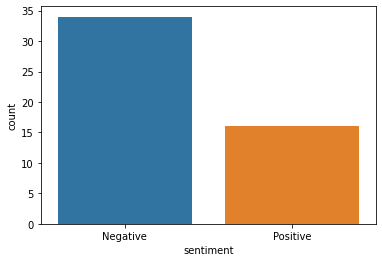

In [16]:
sns.countplot(x='sentiment', data=df_web_cat)
plt.show()

Nous remarquons une dissymétrie entre les modalités `Positive` et `Negative`. Il faudra donc se concentrer sur la métrique `balanced accuracy` plutôt que `accuracy` lors des tests sur les tweets catégorisés à la main.

# 2. Performances des modèles précédents

On fait attention à bien fitter le vectorizer sur les bases Sentiment140 et sur les tweets webscrapés.

In [17]:
class Modelisation():
    def __init__(self, X_labeled, y_labeled, X_unlabeled, X_unlabeled_cat, y_unlabeled_cat, vectorizer, model, scaling=True):
        vectorizer.fit(X_labeled + X_unlabeled)
        X_labeled = vectorizer.transform(X_labeled)

        if scaling:
            scaler = StandardScaler(with_mean=False)
            X_labeled = scaler.fit_transform(X_labeled)

        X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, train_size=0.80, random_state=1234)

        model.fit(X_train_labeled, y_train_labeled)    
        y_pred_labeled = model.predict(X_test_labeled)

        X_unlabeled_cat = vectorizer.transform(X_unlabeled_cat)
        if scaling:
            X_unlabeled_cat = scaler.transform(X_unlabeled_cat)
        y_pred_unlabeled_cat = model.predict(X_unlabeled_cat)
        
        self.X_test_labeled = X_test_labeled
        self.y_test_labeled = y_test_labeled
        self.y_pred_labeled = y_pred_labeled
        self.X_unlabeled_cat = X_unlabeled_cat
        self.y_unlabeled_cat = y_unlabeled_cat
        self.y_pred_unlabeled_cat = y_pred_unlabeled_cat
        self.vectorizer = vectorizer
        self.model = model
        self.scaling = scaling
        
        if scaling:
            self.scaler = scaler
    
    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self, X_test, y_test, y_pred):
        metrics.plot_confusion_matrix(self.model, X_test, y_test, cmap='Blues')
        plt.show()
        
        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)        
        sc_roc_auc = metrics.roc_auc_score(y_test, self.model.predict_proba(X_test)[:, 1])        

        print(f"Accuracy : {sc_accuracy:.4f}")
        print(f"Balanced accuracy : {sc_balanced_accuracy:.4f}")
        print(f"ROC AUC : {sc_roc_auc:.4f}")
        
    def show_conf_matrix_labeled(self):
        print("\nDonnées labellisées de test (Sentiment140)")
        self.show_conf_matrix(self.X_test_labeled, self.y_test_labeled, self.y_pred_labeled)
        
    def show_conf_matrix_unlabeled(self):
        print("\nDonnées non labellisées (Webscraping labellisé à la main)")
        self.show_conf_matrix(self.X_unlabeled_cat, self.y_unlabeled_cat, self.y_pred_unlabeled_cat)
    
    def predict(self, X):
        X = self.vectorizer.transform(X)
        if self.scaling:
            X = self.scaler.transform(X)
        return self.model.predict(X)

In [18]:
def data(stop_words, lemmatization, negation):
    """
    Chargement de la base Sentiment140 et des tweets webscrapés
    """
    file = "train"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    df_140 = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(NB_DATA_140, random_state=1234).reset_index(drop=True)

    file = "web"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    df_web = pd.read_pickle(os.path.join("data", "web", file + ".bz2"))

    df_temp = pd.read_excel(os.path.join("data", "web", "cat_.xlsx")).drop(columns=['Unnamed: 0', 'text_trad'])
    df_temp.sentiment = df_temp.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')

    assert (df_web_cat.text == df_temp.text).all()

    df_web_cat['sentiment'] = df_temp.sentiment

    X_140 = df_140.text.to_list()
    y_140 = df_140.sentiment.to_list()
    y_140_bool = (np.array(y_140) == 'Positive').astype(int).tolist()

    X_web = df_web.text.to_list()
    X_web_cat = df_web_cat.text.to_list()
    y_web_cat = df_web_cat.sentiment.to_list()
    y_web_cat_bool = (np.array(y_web_cat) == 'Positive').astype(int).tolist()
    
    return X_140, y_140, y_140_bool, X_web, X_web_cat, y_web_cat, y_web_cat_bool

## 2.1. Logistic Regression

Nous utilisons le meilleur preprocessing pour ce modèle : `STOP_WORDS = False, LEMMATIZATION = False, NEGATION = False` et les meilleurs paramètres trouvés dans l'étude du modèle (notebook `model-LR.ipynb`).

In [19]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
X_140, y_140, y_140_bool, X_web, X_web_cat, y_web_cat, y_web_cat_bool = data(STOP_WORDS, LEMMATIZATION, NEGATION)


Données labellisées de test (Sentiment140)


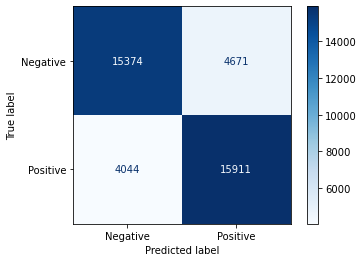

Accuracy : 0.7821
Balanced accuracy : 0.7824
ROC AUC : 0.8524

Données non labellisées (Webscraping labellisé à la main)


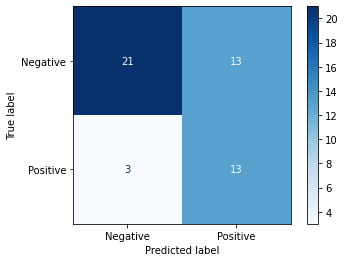

Accuracy : 0.6800
Balanced accuracy : 0.6875
ROC AUC : 0.7868
Wall time: 8.8 s


In [20]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, CountVectorizer(max_features=6000), LogisticRegression())
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()


Données labellisées de test (Sentiment140)


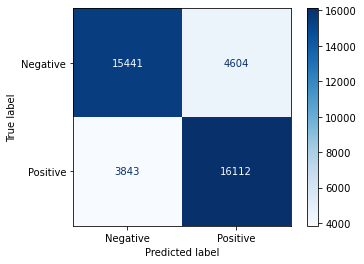

Accuracy : 0.7888
Balanced accuracy : 0.7892
ROC AUC : 0.8623

Données non labellisées (Webscraping labellisé à la main)


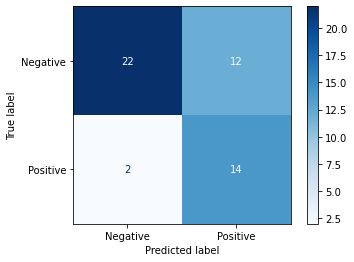

Accuracy : 0.7200
Balanced accuracy : 0.7276
ROC AUC : 0.7316
Wall time: 17.9 s


In [21]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, CountVectorizer(max_features=6000, ngram_range=(1, 2)), LogisticRegression(max_iter=500))
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()


Données labellisées de test (Sentiment140)


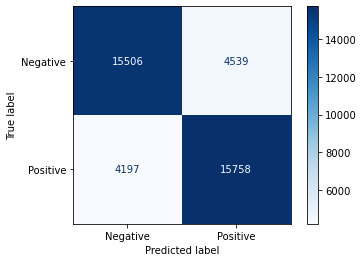

Accuracy : 0.7816
Balanced accuracy : 0.7817
ROC AUC : 0.8615

Données non labellisées (Webscraping labellisé à la main)


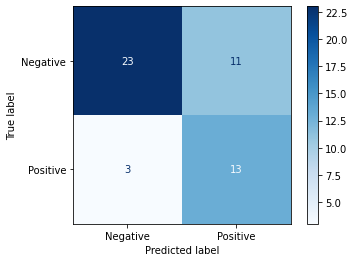

Accuracy : 0.7200
Balanced accuracy : 0.7131
ROC AUC : 0.8051
Wall time: 6.74 s


In [22]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, TfidfVectorizer(max_features=6000), LogisticRegression())
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()


Données labellisées de test (Sentiment140)


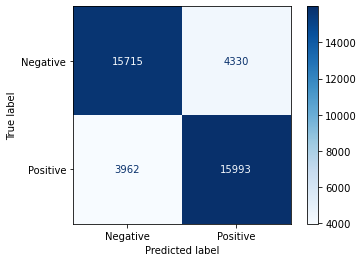

Accuracy : 0.7927
Balanced accuracy : 0.7928
ROC AUC : 0.8718

Données non labellisées (Webscraping labellisé à la main)


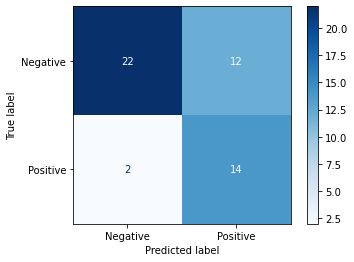

Accuracy : 0.7200
Balanced accuracy : 0.7276
ROC AUC : 0.7665
Wall time: 15.9 s


In [23]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, TfidfVectorizer(max_features=6000, ngram_range=(1, 2)), LogisticRegression(max_iter=500))
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Les meilleurs performances sont atteintes avec la méthode de feature extraction `TfidfVectorizer(max_features=6000, ngram_range=(1, 2))` ce qui correspond bien à ce que l'on avait trouvé dans l'étude du modèle.

## 2.2. Multinomial Naive Bayes

Nous utilisons le meilleur preprocessing pour ce modèle : `STOP_WORDS = False, LEMMATIZATION = True, NEGATION = False` et les meilleurs paramètres trouvés dans l'étude du modèle (notebook `model-NB.ipynb`).

In [24]:
STOP_WORDS = False
LEMMATIZATION = True
NEGATION = False
X_140, y_140, y_140_bool, X_web, X_web_cat, y_web_cat, y_web_cat_bool = data(STOP_WORDS, LEMMATIZATION, NEGATION)


Données labellisées de test (Sentiment140)


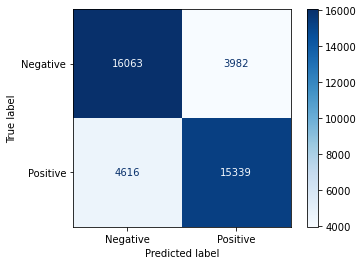

Accuracy : 0.7851
Balanced accuracy : 0.7853
ROC AUC : 0.8539

Données non labellisées (Webscraping labellisé à la main)


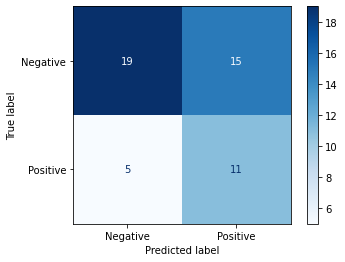

Accuracy : 0.6000
Balanced accuracy : 0.6074
ROC AUC : 0.6673
Wall time: 13 s


In [25]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, CountVectorizer(max_features=40097, ngram_range=(1, 2)), MultinomialNB(alpha=1), scaling=False)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()


Données labellisées de test (Sentiment140)


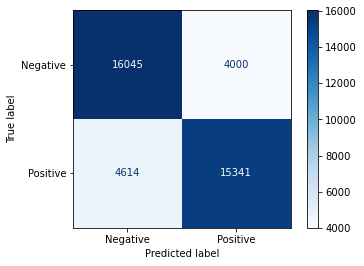

Accuracy : 0.7846
Balanced accuracy : 0.7849
ROC AUC : 0.8673

Données non labellisées (Webscraping labellisé à la main)


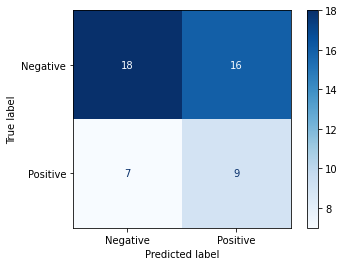

Accuracy : 0.5400
Balanced accuracy : 0.5400
ROC AUC : 0.5864
Wall time: 12.6 s


In [26]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, TfidfVectorizer(max_features=40097, ngram_range=(1, 2)), MultinomialNB(alpha=1), scaling=False)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Les performances du modèle **Naive Bayes** sont proches de celles du modèle **Logistic Regression** sur les données Sentiment140. Cependant le modèle **Naive Bayes** s'adapte moins aux tweets webscrapés et offrent de moins bonnes performances que le modèle **Logistic Regression**. 

# 3. Apprentissage semi-supervisé

Pour essayer d'améliorer les performances du modèle **Naive Bayes** nous tentons une méthode d'apprentissage semi-supervisé qui va utiliser des tweets webscrappés labbelisés à la main. 

Ce site présente un exemple du modèle de classification **Naive Bayes Semi-Supervised* : https://matpalm.com/semi_supervised_naive_bayes/semi_supervised_bayes.html.

Nous utilisons une modification du modèle MultinomialNB de Scikit-Learn disponible sur ce projet : https://github.com/jmatayoshi/semi-supervised-naive-bayes.

In [27]:
from semi_supervised_naive_bayes import MultinomialNBSS

In [28]:
class ModelisationSemi(Modelisation):
    def __init__(self, X_labeled, y_labeled_bool, X_unlabeled, X_unlabeled_cat, y_unlabeled_cat_bool, vectorizer, facteur=None, alpha=1, beta=1):
        if facteur or facteur == 0:
            correction = int((len(X_labeled) / (len(X_unlabeled))) * facteur)
            X_unlabeled_fac = X_unlabeled * correction
        else:
            X_unlabeled_fac = X_unlabeled            
        
        print(f"Nombre de lignes base labellisée (Sentiment140)    : {len(X_labeled)}")
        print(f"Nombre de lignes base non labellisée (Webscraping) : {len(X_unlabeled_fac)}")    
    
        X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled_bool, train_size=0.80, random_state=1234)
    
        X_train_all = X_train_labeled + X_unlabeled_fac
        y_train_all = y_train_labeled + [-1] * len(X_unlabeled_fac)
        
        # On applique le vectorizer sur l'ensemble des données
        vectorizer.fit(X_labeled + X_unlabeled)
        X_train_all = vectorizer.transform(X_train_all)
        
        model = MultinomialNBSS(alpha=alpha, beta=beta)
        model.fit(X_train_all, y_train_all)        
        
        X_test_labeled = vectorizer.transform(X_test_labeled)    
        y_pred_labeled = model.predict(X_test_labeled)
        
        X_unlabeled_cat = vectorizer.transform(X_unlabeled_cat)
        y_pred_unlabeled_cat = model.predict(X_unlabeled_cat)
        
        self.X_test_labeled = X_test_labeled
        self.y_test_labeled = y_test_labeled
        self.y_pred_labeled = y_pred_labeled
        self.X_unlabeled_cat = X_unlabeled_cat
        self.y_unlabeled_cat = y_unlabeled_cat_bool
        self.y_pred_unlabeled_cat = y_pred_unlabeled_cat
        self.vectorizer = vectorizer
        self.model = model

Le paramètre `facteur` permet d'augmenter artificiellement le nombre de tweets webscrapés en les dupliquant.

Le paramètre `beta` permet de faire varier le poids des tweets webscrapés dans l'apprentissage semi-supervisé.

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 0

Données labellisées de test (Sentiment140)


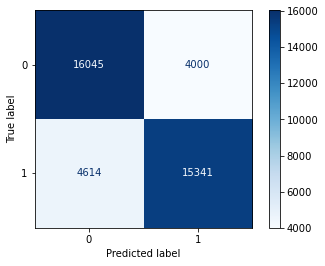

Accuracy : 0.7846
Balanced accuracy : 0.7849
ROC AUC : 0.8673

Données non labellisées (Webscraping labellisé à la main)


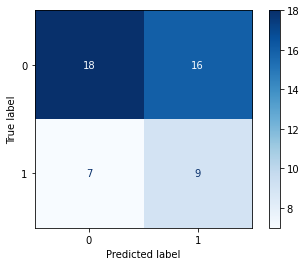

Accuracy : 0.5400
Balanced accuracy : 0.5400
ROC AUC : 0.5864
Wall time: 14.1 s


In [29]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=40097, ngram_range=(1, 2)), facteur=0)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 10588
Step 1: jll = -12039367.980201
Step 2: jll = -12039800.492279
Step 3: jll = -12040728.342720
Step 4: jll = -12042248.714799
Step 5: jll = -12044346.583454
Step 6: jll = -12046772.596444
Step 7: jll = -12049036.971736
Step 8: jll = -12050764.143298
Step 9: jll = -12051894.685297
Step 10: jll = -12052564.702146
Step 11: jll = -12052939.317543
Step 12: jll = -12053142.152069
Step 13: jll = -12053250.113645
Step 14: jll = -12053307.065160
Step 15: jll = -12053336.968416
Step 16: jll = -12053352.631698
Step 17: jll = -12053360.825835
Step 18: jll = -12053365.109755
Step 19: jll = -12053367.348645
Step 20: jll = -12053368.518542
Optimization converged after 20 iterations.

Données labellisées de test (Sentiment140)


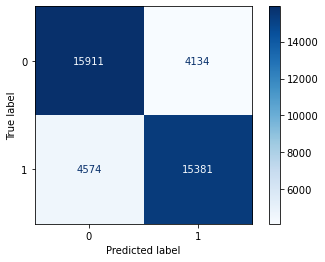

Accuracy : 0.7823
Balanced accuracy : 0.7824
ROC AUC : 0.8633

Données non labellisées (Webscraping labellisé à la main)


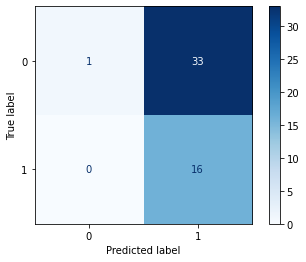

Accuracy : 0.3400
Balanced accuracy : 0.6633
ROC AUC : 0.5515
Wall time: 14.2 s


In [30]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=40097, ngram_range=(1, 2)), facteur=None)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 190584
Step 1: jll = -29288809.696493
Step 2: jll = -29297311.980662
Step 3: jll = -29318876.725492
Step 4: jll = -29351766.173137
Step 5: jll = -29389298.199939
Step 6: jll = -29430366.707994
Step 7: jll = -29479831.862834
Step 8: jll = -29543954.196305
Step 9: jll = -29631010.809704
Step 10: jll = -29748862.599143
Step 11: jll = -29893973.229690
Step 12: jll = -30039019.286584
Step 13: jll = -30151028.168925
Step 14: jll = -30222229.317940
Step 15: jll = -30263967.430820
Step 16: jll = -30289429.966719
Step 17: jll = -30305557.645624
Step 18: jll = -30314959.674436
Step 19: jll = -30320362.932499
Step 20: jll = -30323588.416144
Optimization converged after 20 iterations.

Données labellisées de test (Sentiment140)


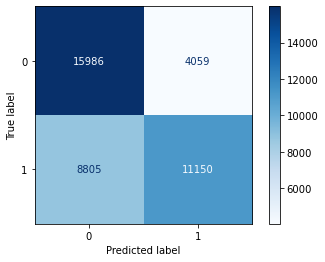

Accuracy : 0.6784
Balanced accuracy : 0.6890
ROC AUC : 0.7594

Données non labellisées (Webscraping labellisé à la main)


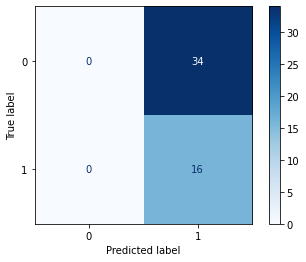

Accuracy : 0.3200
Balanced accuracy : 0.3200
ROC AUC : 0.5662
Wall time: 24.8 s


C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [31]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=40097, ngram_range=(1, 2)), facteur=1)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 10588
Step 1: jll = -12039367.980201
Step 2: jll = -12039800.492279
Step 3: jll = -12040728.342720
Step 4: jll = -12042248.714799
Step 5: jll = -12044346.583454
Step 6: jll = -12046772.596444
Step 7: jll = -12049036.971736
Step 8: jll = -12050764.143298
Step 9: jll = -12051894.685297
Step 10: jll = -12052564.702146
Step 11: jll = -12052939.317543
Step 12: jll = -12053142.152069
Step 13: jll = -12053250.113645
Step 14: jll = -12053307.065160
Step 15: jll = -12053336.968416
Step 16: jll = -12053352.631698
Step 17: jll = -12053360.825835
Step 18: jll = -12053365.109755
Step 19: jll = -12053367.348645
Step 20: jll = -12053368.518542
Optimization converged after 20 iterations.

Données labellisées de test (Sentiment140)


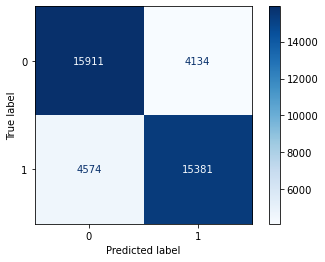

Accuracy : 0.7823
Balanced accuracy : 0.7824
ROC AUC : 0.8633

Données non labellisées (Webscraping labellisé à la main)


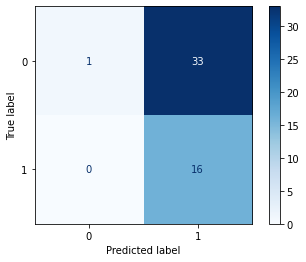

Accuracy : 0.3400
Balanced accuracy : 0.6633
ROC AUC : 0.5515
Wall time: 14.7 s


In [32]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=40097, ngram_range=(1, 2)), beta=1)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 10588
Step 1: jll = -12062595.646823
Step 2: jll = -12062802.147287
Step 3: jll = -12063697.059429
Step 4: jll = -12065388.672732
Step 5: jll = -12068109.604727
Step 6: jll = -12071687.871951
Step 7: jll = -12075233.032808
Step 8: jll = -12077881.853411
Step 9: jll = -12079485.963958
Step 10: jll = -12080342.782601
Step 11: jll = -12080771.562355
Step 12: jll = -12080979.498788
Step 13: jll = -12081078.870704
Step 14: jll = -12081126.041052
Step 15: jll = -12081148.362964
Step 16: jll = -12081158.911098
Step 17: jll = -12081163.892287
Step 18: jll = -12081166.243845
Step 19: jll = -12081167.353820
Step 20: jll = -12081167.877709
Optimization converged after 20 iterations.

Données labellisées de test (Sentiment140)


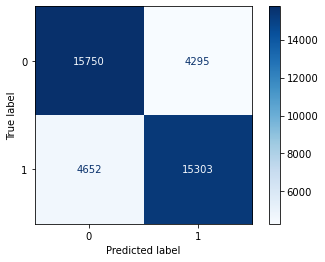

Accuracy : 0.7763
Balanced accuracy : 0.7764
ROC AUC : 0.8565

Données non labellisées (Webscraping labellisé à la main)


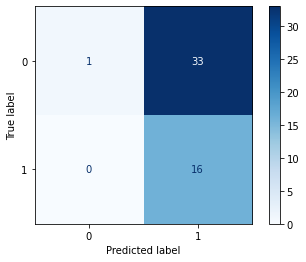

Accuracy : 0.3400
Balanced accuracy : 0.6633
ROC AUC : 0.5368
Wall time: 14.2 s


In [33]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=40097, ngram_range=(1, 2)), beta=2)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Nombre de lignes base labellisée (Sentiment140)    : 200000
Nombre de lignes base non labellisée (Webscraping) : 10588
Step 1: jll = -12161816.704031
Step 2: jll = -12161454.618300
Optimization converged after 2 iterations.

Données labellisées de test (Sentiment140)


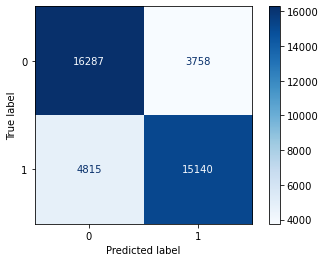

Accuracy : 0.7857
Balanced accuracy : 0.7865
ROC AUC : 0.8673

Données non labellisées (Webscraping labellisé à la main)


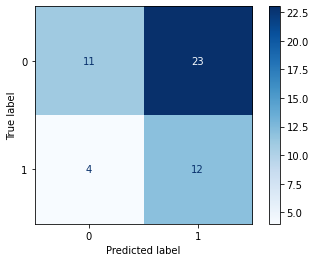

Accuracy : 0.4600
Balanced accuracy : 0.5381
ROC AUC : 0.5974
Wall time: 13.2 s


In [34]:
%%time
m = ModelisationSemi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=40097, ngram_range=(1, 2)), beta=5)
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

Après plusieurs essais, nous ne trouvons pas de meilleures performances. Une étude plus appronfondie des paramètres serait nécessaire (avec un GridSearch par exemple).

# 4. Conclusion

Nous appliquons finalement le modèle de régression logistique, qui s'avère être le plus performant, sur l'ensemble des tweets webscrapés.

In [35]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
X_140, y_140, y_140_bool, X_web, X_web_cat, y_web_cat, y_web_cat_bool = data(STOP_WORDS, LEMMATIZATION, NEGATION)


Données labellisées de test (Sentiment140)


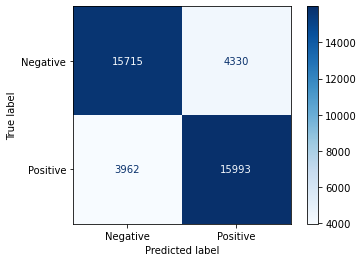

Accuracy : 0.7927
Balanced accuracy : 0.7928
ROC AUC : 0.8718

Données non labellisées (Webscraping labellisé à la main)


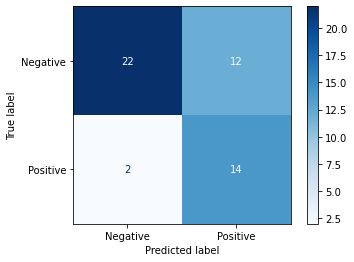

Accuracy : 0.7200
Balanced accuracy : 0.7276
ROC AUC : 0.7665
Wall time: 15.9 s


In [36]:
%%time
m = Modelisation(X_140, y_140, X_web, X_web_cat, y_web_cat, TfidfVectorizer(max_features=6000, ngram_range=(1,2)), LogisticRegression(max_iter=500))
m.show_conf_matrix_labeled()
m.show_conf_matrix_unlabeled()

In [37]:
%%time
resul = m.predict(X_web)

Wall time: 412 ms


In [38]:
resul

array(['Positive', 'Positive', 'Positive', ..., 'Negative', 'Positive',
       'Negative'], dtype='<U8')

In [39]:
df_web['sentiment'] = resul
df_web['month'] = [time.month for time in df_web['time']]
df_web.head(10)

,search,author,time,url,text,lang,reply,sentiment,month
0,biden,Maggie Klaus 🤶🏻,2019-01-01 22:37:46,/Maggie_Klaus/status/1080231636334067712,shut the f ck up about hillary s likability wh...,en,False,Positive,1
1,biden,The Salt Lake Tribune,2019-01-01 22:15:18,/sltrib/status/1080225983083487232,the agreed to pay former vice president to spe...,en,False,Positive,1
2,biden,The New York Times,2019-01-01 20:00:08,/nytimes/status/1080191967873716224,a series of careful financial decisions and th...,en,False,Positive,1
3,biden,Matt Binder,2019-01-01 22:18:51,/MattBinder/status/1080226876226965504,i agree this is useful democrats should defini...,en,False,Positive,1
4,biden,Patrick Healy,2019-01-01 19:58:58,/patrickhealynyt/status/1080191673701933059,news joe biden s campaign in waiting includes ...,en,False,Positive,1
5,biden,Ashton Pittman,2019-01-01 23:52:34,/ashtonpittman/status/1080250459200344065,also on fox news newt gingrich praised sen mar...,en,False,Positive,1
6,biden,Ashton Pittman,2019-01-01 23:52:35,/ashtonpittman/status/1080250465718288384,republicans at fox news even had high praise f...,en,False,Positive,1
7,biden,Virgil Xmas 🎄🎁💸,2019-01-01 22:25:54,/virgiltexas/status/1080228651327733760,for every joe biden he votes for i am going to...,en,False,Positive,1
8,biden,Katelyn Burns,2019-01-01 22:01:53,/transscribe/status/1080222604668166144,the unspoken and untrue premise of this piece ...,en,False,Positive,1
9,biden,Susan Murphy,2019-01-01 22:59:08,/susmurphy/status/1080237012689530883,re the dem race i will vote for whoever is the...,en,False,Positive,1


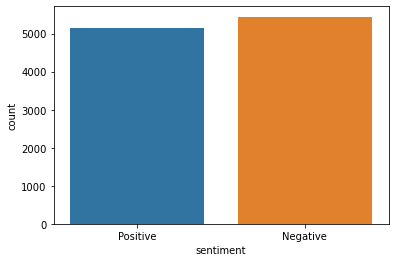

In [40]:
sns.countplot(x='sentiment', data=df_web)
plt.show()

<AxesSubplot:xlabel='search', ylabel='count'>

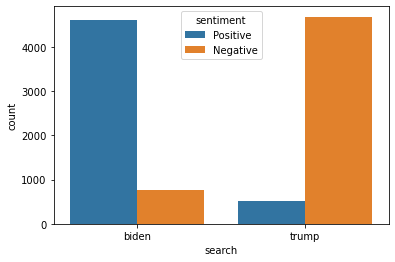

In [41]:
sns.countplot(x='search', hue='sentiment', data=df_web)

<AxesSubplot:xlabel='month', ylabel='count'>

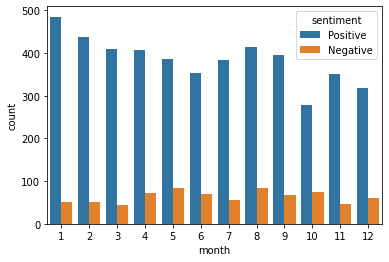

In [42]:
sns.countplot(x='month', hue='sentiment', data=df_web.loc[df_web['search'] == 'biden'])

<AxesSubplot:xlabel='month', ylabel='count'>

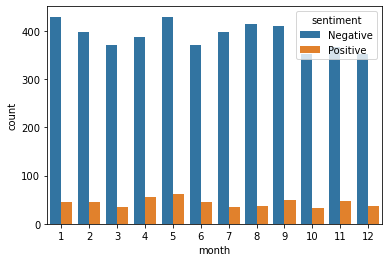

In [43]:
sns.countplot(x='month', hue='sentiment', data=df_web.loc[df_web['search'] == 'trump'])

In [44]:
def proportion_positive_by_month(search):
    series = df_web[['search', 'month', 'sentiment']].loc[df_web['search'] == search].value_counts().sort_index()
    L = []
    for i in range(12):
        L.append(series[2 * i + 1] / (series[2 * i] + series[2 * i + 1]))
    return L

proportion_positive_by_month('trump')

[0.09473684210526316,
 0.10158013544018059,
 0.085995085995086,
 0.12641083521444696,
 0.12423625254582485,
 0.11004784688995216,
 0.08083140877598152,
 0.07982261640798226,
 0.10869565217391304,
 0.08571428571428572,
 0.11538461538461539,
 0.09511568123393316]

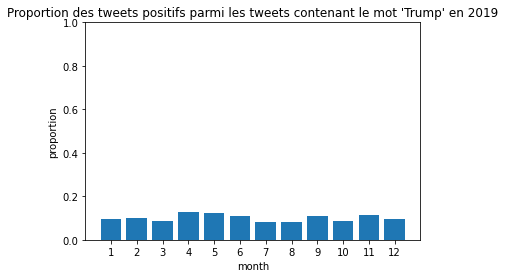

In [45]:
names = [str(i) for i in range(1, 13)]
plt.bar(names, proportion_positive_by_month('trump'))
plt.ylim(0, 1)
plt.xlabel('month')
plt.ylabel('proportion')
plt.title("Proportion des tweets positifs parmi les tweets contenant le mot 'Trump' en 2019")
plt.show()

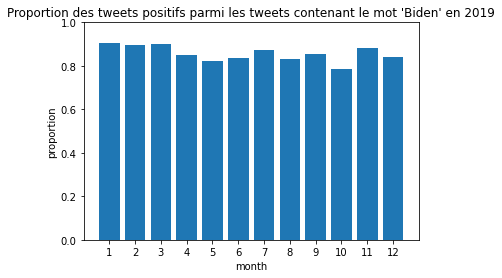

In [46]:
names = [str(i) for i in range(1, 13)]
plt.bar(names, proportion_positive_by_month('biden'))
plt.ylim(0, 1)
plt.xlabel('month')
plt.ylabel('proportion')
plt.title("Proportion des tweets positifs parmi les tweets contenant le mot 'Biden' en 2019")
plt.show()

In [47]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:03:40
